In [7]:
import tensorflow as tf
from math import ceil
from configuration import *

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [8]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [9]:
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

tf.random.set_seed(SEED)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44


In [10]:
from dataset_utils import create_paired_s2s_image_loader as create_image_loader
# from dataset_utils import create_paired_s2s_image_loader_indexed_images as create_image_loader

train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test", False))
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

# f2b_train_dataset = train_dataset.map(create_image_loader(2, 0, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
# f2b_train_dataset = f2b_train_dataset.batch(BATCH_SIZE)
# f2b_test_dataset = test_dataset.map(create_image_loader(2, 0, TEST_SIZES, "test", False))
# f2b_test_dataset = f2b_test_dataset.batch(BATCH_SIZE)
#
# f2l_train_dataset = train_dataset.map(create_image_loader(2, 1, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
# f2l_train_dataset = f2l_train_dataset.batch(BATCH_SIZE)
# f2l_test_dataset = test_dataset.map(create_image_loader(2, 1, TEST_SIZES, "test", False))
# f2l_test_dataset = f2l_test_dataset.batch(BATCH_SIZE)

In [11]:
# from networks import PatchDiscriminator
#
# dsc = PatchDiscriminator(30)
# dsc.summary()

In [12]:
# loader = create_image_loader(2, 3, TRAIN_SIZES, "train", False)
# input_image, target_image, palette = loader(0)
# print("input_image", input_image)
# print(tf.reshape(tf.one_hot(input_image, 256, axis=-1), [64, 64, -1]))
#
#
# from networks import IndexedPatchDiscriminator, IndexedUnetGenerator
# discriminator = IndexedPatchDiscriminator(num_patches=30)
# generator = IndexedUnetGenerator()
#
# discriminator.summary()
# discriminator([input_image[None, :], target_image[None, :]], training=True)
#
#
# generator.summary()
# fake_image = generator(input_image[None, :], training=True)[0]
# fake_image = tf.argmax(fake_image, axis=-1)
# fake_image = io_utils.indexed_to_rgba(fake_image, palette)
# print(fake_image)



In [13]:
# tf.repeat([[255, 0, 220, 255]], [MAX_PALETTE_SIZE - 56,], axis=0)

In [14]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(8, 8))
# plt.title("Indexed generated at 0")
# plt.imshow(fake_image)
# plt.axis("off")

In [15]:
# from pix2pix_model import Unet2Generator
# gen = Unet2Generator()
# gen.summary()

In [16]:
from pix2pix_model import Pix2PixModel, Pix2PixIndexedModel#, Pix2PixWassersteinModel#, Pix2PixFFTModel

# f2r = Pix2PixFFTModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-fftsquare1000", LAMBDA_FFT=1000)
model = Pix2PixModel.build(f2r_train_dataset, f2r_test_dataset, "alpha-0.5", "histogram", "patch-resnet", "unet", "wgan", discriminator_steps=1, lambda_histogram=0.5, lambda_l1=1.0, lambda_gp=10.)
# model = Pix2PixIndexedModel(f2r_train_dataset, f2r_test_dataset, "indexed-patchresnetdisc-reducedcapacities", "indexed-cost", "indexed-patch-resnet", "indexed-unet", "gan", discriminator_steps=1, lambda_l1=0., lambda_segmentation=0.1)


lambda_histogram 0.5


In [17]:
EPOCHS = 160
STEPS = ceil(TRAIN_SIZE / BATCH_SIZE) * EPOCHS
UPDATE_STEPS = STEPS // 40
SHOULD_SAVE_RESULTS = False
SHOULD_GENERATE_ALL_IMAGES_FROM_TEST = True

print(f"Starting training for {EPOCHS} epochs in {STEPS} steps, updating visualization every {UPDATE_STEPS} steps...")

Starting training for 160 epochs in 5120 steps, updating visualization every 128 steps...


Time since start: 37m:40s
Estimated time to finish: 01h:27m:56s
Last 128 steps took: 183.34s



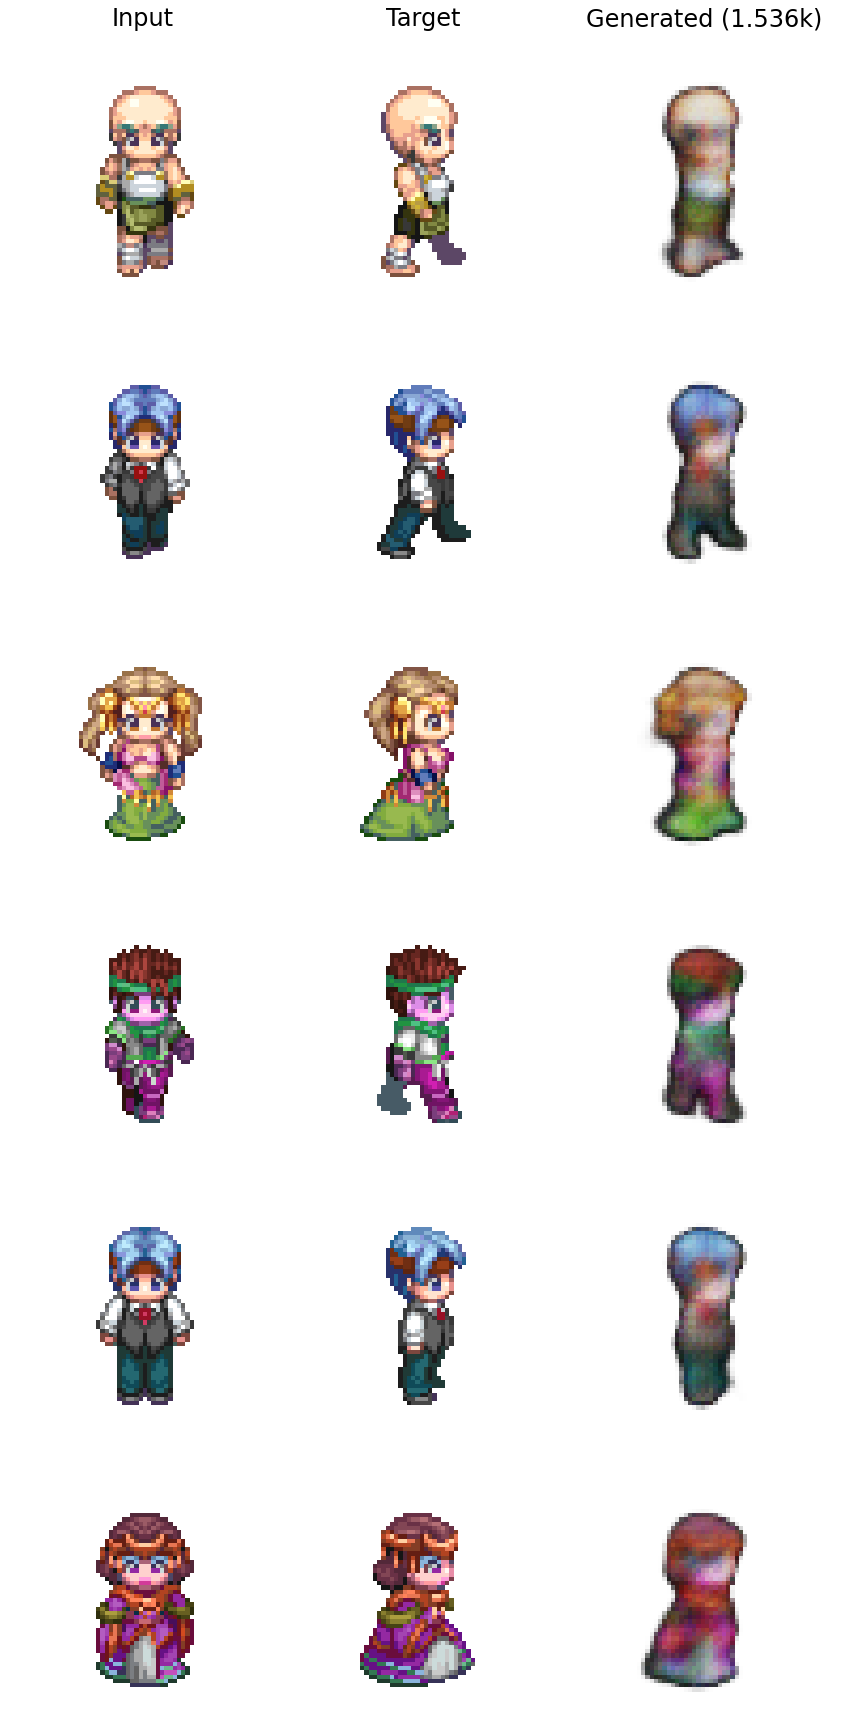

Calculating Fréchet Inception Distance at 1.536k with 44 examples... FID: 28.686 / 30.386 (train/test)
Showing discriminator patches


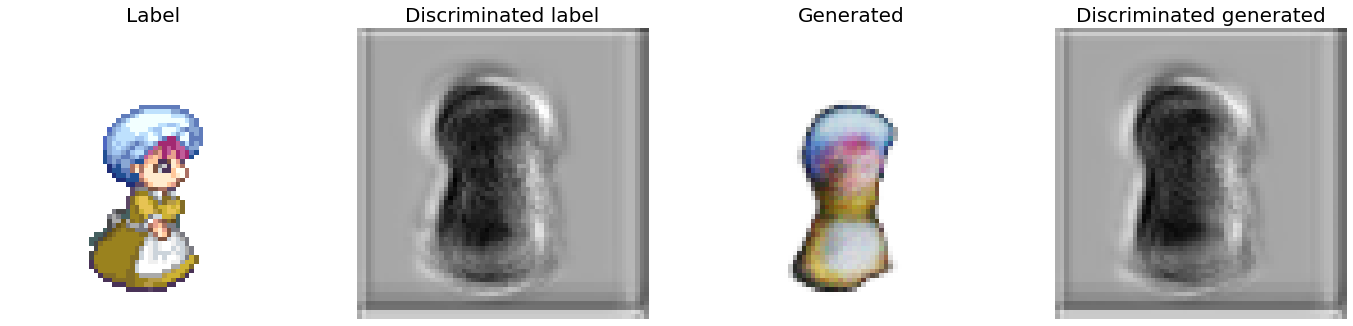

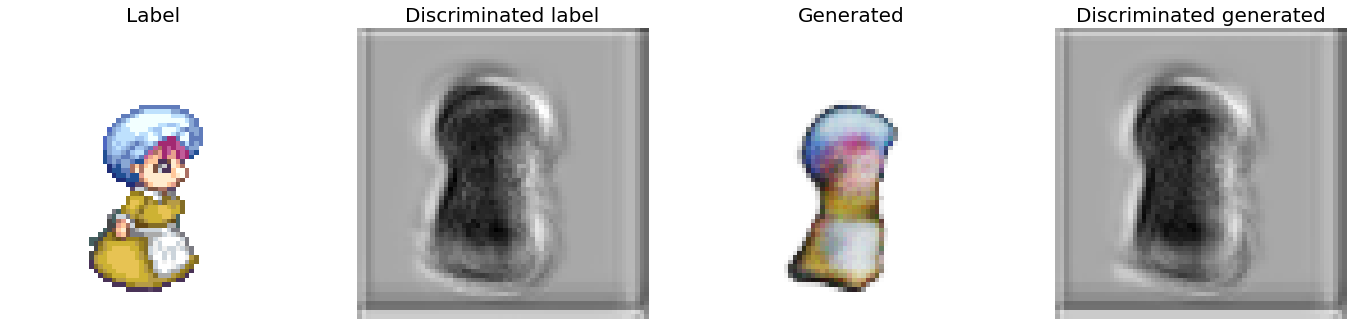

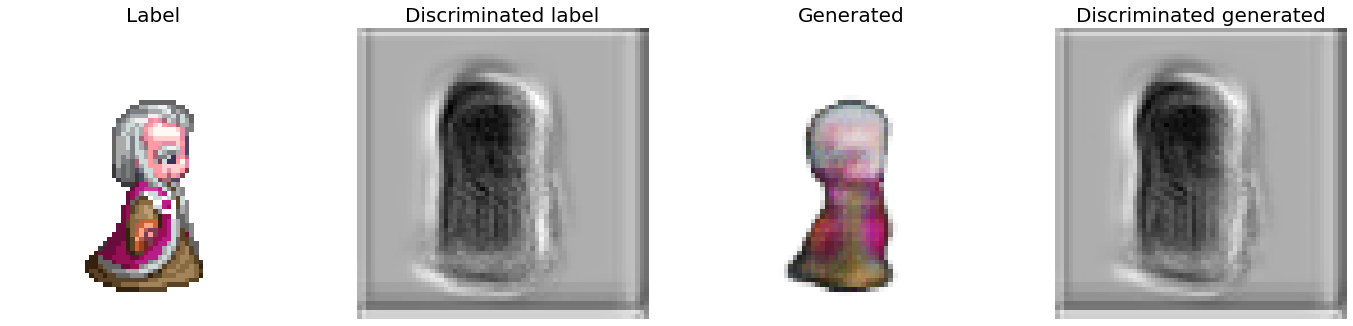

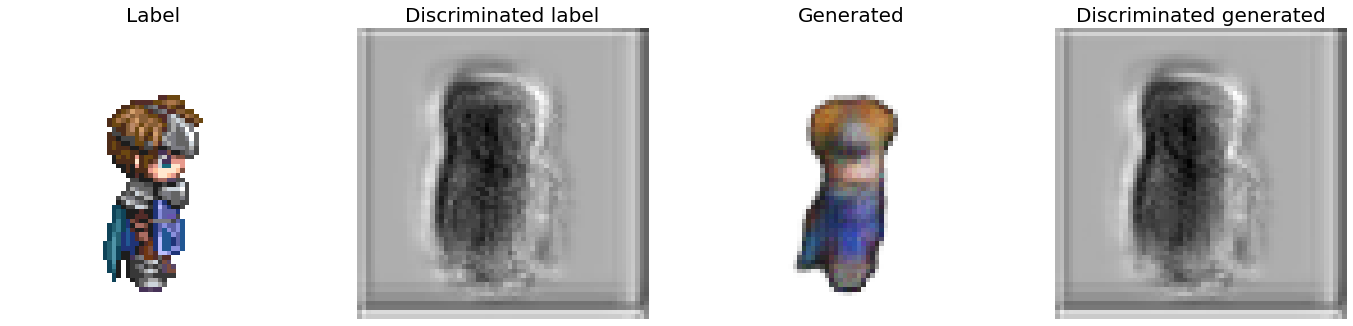

Step: 1.536k
˯˯˯˯˯˯˯˯˯˯˯˯
.........

In [ ]:
model.fit(STEPS, UPDATE_STEPS, callbacks=["show_patches", "fid"])


In [ ]:
# print("More training...")
# model.save_generator()
# model = Pix2PixModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-unetafterunet-unet", "unet", "unet", LAMBDA=100.)
# model.generator = tf.keras.models.load_model(os.sep.join(["models", "py", "generator", "pix2pix-rpgmakerxp-unet-unet", "front2right"]))
# model.fit(STEPS, UPDATE_STEPS, callbacks=["fid", "show_patches"])


In [ ]:
if SHOULD_GENERATE_ALL_IMAGES_FROM_TEST:
    # f2r.load_generator()
    model.generate_images_from_dataset()

In [ ]:
if SHOULD_SAVE_RESULTS:
    model.save_generator()
    model.save_discriminator()

In [ ]:
# print("Showing discriminator output from TRAIn set...")
# model.show_discriminated_images("train")
# print("Showing discriminator output from TEST set...")
# model.show_discriminated_images("test")

In [ ]:
# model.load_generator()
# model.generate_images_from_dataset(dataset_name="train", num_images=3)
#
# print("Discriminated images from test")
# model.load_discriminator()
# model.show_discriminated_images("train")